# Simple Text Classifier for "20 News Group" dataset

In [1]:
import _pickle as cPickle
import tarfile

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

In [3]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding="latin1")
    fo.close()
    return dict

## Sample pipeline for text feature extraction and evaluation


The dataset used in this example is the 20 newsgroups dataset which will be
automatically downloaded and then cached and reused for the document
classification example.

<PRE>
>>> from sklearn.datasets import fetch_20newsgroups
>>> newsgroups_train = fetch_20newsgroups(subset='train')

>>> from pprint import pprint
>>> pprint(list(newsgroups_train.target_names))
['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
</PRE>
We can adjust the number of categories by giving their names to the dataset
loader or setting them to None to get the 20 of them.

Here is a sample output of a run on a quad-core machine::

<PRE>  Loading 20 newsgroups dataset for categories:
  ['alt.atheism', 'talk.religion.misc']
  1427 documents
  2 categories
  
  
  Performing grid search...
  pipeline: ['vect', 'tfidf', 'clf']
  parameters:
  {'clf__alpha': (1.0000000000000001e-05, 9.9999999999999995e-07),
   'clf__n_iter': (10, 50, 80),
   'clf__penalty': ('l2', 'elasticnet'),
   'tfidf__use_idf': (True, False),
   'vect__max_n': (1, 2),
   'vect__max_df': (0.5, 0.75, 1.0),
   'vect__max_features': (None, 5000, 10000, 50000)}
  done in 1737.030s

  Best score: 0.940
  Best parameters set:
      clf__alpha: 9.9999999999999995e-07
      clf__n_iter: 50
      clf__penalty: 'elasticnet'
      tfidf__use_idf: True
      vect__max_n: 2
      vect__max_df: 0.75
      vect__max_features: 50000
</PRE>

## From documents to a "document by term" frequency matrix  

Convert a set of  documents to a "document by term" frequency matrix

The following corpus: 

`corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]`

gets converted to a "document by term" frequency matrix

`array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]]
       `

where the 9 columns are labeled with the following 9 words extracted:

`['and', 'document', 'first', 'is', 'one',
      'second', 'the', 'third', 'this']`
      
By default, words of length 2 characters or more a kept as the vocabulary.

For more details see (here)[http://scikit-learn.org/stable/modules/feature_extraction.html]

In [5]:
# Let’s use the following corpus (text dataset).
corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]

In [6]:
#CountVectorizer implements both tokenization and occurrence counting in a single class:
from sklearn.feature_extraction.text import CountVectorizer

# Here we will tokenize and count the word occurrences of this minimalistic corpus of text documents:
vectorizer = CountVectorizer() 
X = vectorizer.fit_transform(corpus)
X                              
#<4x9 sparse matrix of type '<... 'numpy.int64'>'
#    with 19 stored elements in Compressed Sparse ... format>

<4x9 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [7]:
# The default configuration tokenizes the string by extracting words of at least 2 
# letters. The specific function that does this step can be requested explicitly:  
analyze = vectorizer.build_analyzer()
analyze("This is a text document to analyze.") == (
    ['this', 'is', 'text', 'document', 'to', 'analyze'])

True

In [8]:
vectorizer.get_feature_names() == (
     ['and', 'document', 'first', 'is', 'one',
      'second', 'the', 'third', 'this'])

True

In [9]:
X.toarray()     #recover document by term frequency matrix        
#array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
#       [0, 1, 0, 1, 0, 2, 1, 0, 1],
#       [1, 0, 0, 0, 1, 0, 1, 1, 0],
#       [0, 1, 1, 1, 0, 0, 1, 0, 1]]...)

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

## Text classification pipeline

Below we use a generic Linear classifier class, SGDClassifier.  Here different classifiers can be engaged by specifying different loss fucntions. Here are some of the options (note we will focus on Logistic regression that is engaged thru specifying the loss as `'log'`:


`loss : str, default: ‘hinge’

The loss function to be used. Defaults to ‘hinge’, which gives a linear SVM.

The possible options are ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, or a regression loss: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’.

The ‘log’ loss gives logistic regression, a probabilistic classifier. ‘modified_huber’ is another smooth loss that brings tolerance to outliers as well as probability estimates. ‘squared_hinge’ is like hinge but is quadratically penalized. ‘perceptron’ is the linear loss used by the perceptron algorithm. The other losses are designed for regression but can be useful in classification as well; see SGDRegressor for a description.`

In [15]:
# This code is adopted  and has been modified from 
#
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause

from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
%matplotlib inline

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# #############################################################################
# Load some categories from the training set 
categories = [
    'alt.atheism',
    'talk.religion.misc',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),  #http://scikit-learn.org/stable/modules/feature_extraction.html
    ('tfidf', TfidfTransformer()), #ignore for now
    ('clf', SGDClassifier(loss='log')),  #let's use logistic regression
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = { #listed in the form of "step__parameter", e.g, clf__penalty
    'vect__max_df': (0.5, 0.75),
    'vect__max_features': (None, 500),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams (single words) or bigrams (or sequence of words of length 2)
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l1', 'l2', 'elasticnet'),
    #'clf__penalty': ('l1', 'l2', 'elasticnet'),
    'clf__loss': ('log', 'hinge'),  #hinge linear SVM
    #'clf__n_iter': (10, 50, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
    #
    # By default, the GridSearchCV uses a 3-fold cross-validation. However, if it 
    #            detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.
    grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(data.data, data.target)
    print("done in %0.3fs" % (time() - t0))
    print()
    #print("grid_search.cv_results_", grid_search.cv_results_)
    #estimator : estimator object. This is assumed to implement the scikit-learn estimator interface.  
    #            Either estimator needs to provide a score function, or scoring must be passed.
    #Accuracy is the default for classification; feel free to change this to precision, recall, fbeta
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Automatically created module for IPython interactive environment
Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__loss': ('log', 'hinge'),
 'clf__penalty': ('l1', 'l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75),
 'vect__max_features': (None, 500),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 13.9min finished
C:\Users\Devi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


done in 846.232s

Best score: 0.945
Best parameters set:
	clf__alpha: 1e-05
	clf__loss: 'log'
	clf__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__max_features: None
	vect__ngram_range: (1, 2)


## Confusion matrices
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. The confusion matrix itself is relatively simple to understand, but the related terminology can be confusing.

Let's start with an example confusion matrix for a binary classifier (though it can easily be extended to the case of more than two classes):

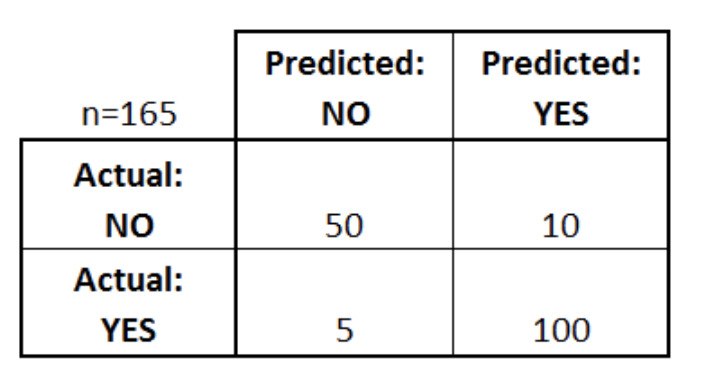

What can we learn from this matrix?

* There are two possible predicted classes: "yes" and "no". If we were predicting the presence of a disease, for example, "yes" would mean they have the disease, and "no" would mean they don't have the disease.
* The classifier made a total of 165 predictions (e.g., 165 patients were being tested for the presence of that disease).
* Out of those 165 cases, the classifier predicted "yes" 110 times, and "no" 55 times.
* In reality, 105 patients in the sample have the disease, and 60 patients do not.

Let's now define the most basic terms, which are whole numbers (not rates):

* true positives (TP): These are cases in which we predicted yes (they have the disease), and they do have the disease.
* true negatives (TN): We predicted no, and they don't have the disease.
* false positives (FP): We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
* false negatives (FN): We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

I've added these terms to the confusion matrix, and also added the row and column totals:

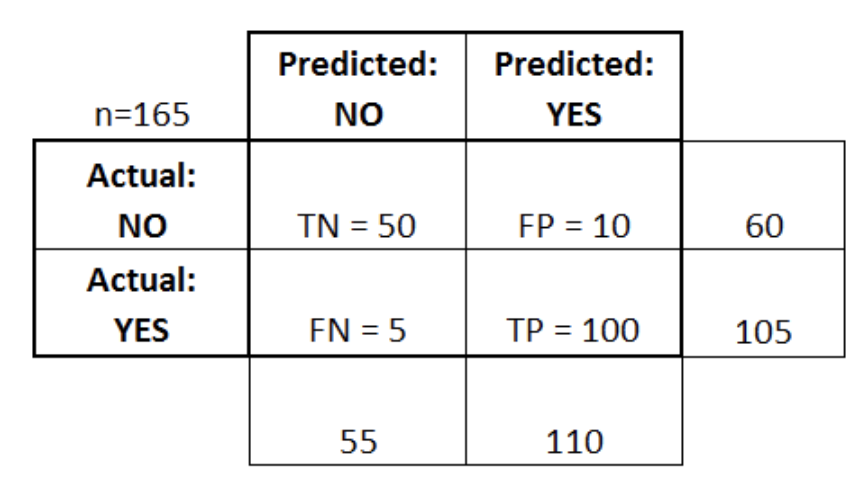

This is a list of rates that are often computed from a confusion matrix for a binary classifier:

* Accuracy: Overall, how often is the classifier correct?
  * (TP+TN)/total = (100+50)/165 = 0.91
* Misclassification Rate: Overall, how often is it wrong?
  * (FP+FN)/total = (10+5)/165 = 0.09
  * equivalent to 1 minus Accuracy
  * also known as "Error Rate"
* True Positive Rate: When it's actually yes, how often does it predict yes?
  * TP/actual yes = 100/105 = 0.95
  * also known as "Sensitivity" or "Recall"
* False Positive Rate: When it's actually no, how often does it predict yes?
  * FP/actual no = 10/60 = 0.17
  * Specificity: When it's actually no, how often does it predict no?
* TN/actual no = 50/60 = 0.83
  * equivalent to 1 minus False Positive Rate
* Precision: When it predicts yes, how often is it correct?
  * TP/predicted yes = 100/110 = 0.91
* Prevalence: How often does the yes condition actually occur in our sample?
  * actual yes/total = 105/165 = 0.64

In [16]:
#***************This is multinomial Naive Bayes and confusion matrix with the results********
from sklearn.feature_extraction.text import TfidfVectorizer
#categories = ['alt.atheism', 'talk.religion.misc',
#               'comp.graphics', 'sci.space']
categories = None
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=categories)
#vectorizer = TfidfVectorizer()
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
print('vectors shape: ', vectors.shape)


from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
newsgroups_test = fetch_20newsgroups(subset='test',
                                     categories=categories)
vectors_test = vectorizer.transform(newsgroups_test.data)
clf = MultinomialNB(alpha=.01)
clf.fit(vectors, newsgroups_train.target)
pred = clf.predict(vectors_test)
print(' F1 score: ', metrics.f1_score(newsgroups_test.target, pred, average='macro') )

print('Auccracy score: ', metrics.accuracy_score(newsgroups_test.target, pred))
# print the confusion matrix
print('Confusion matrics: ', metrics.confusion_matrix(newsgroups_test.target, pred) )


vectors shape:  (11314, 130107)
 F1 score:  0.7852092132952866
Auccracy score:  0.8039033457249071
Confusion matrics:  [[265   1   0   4   0   0   0   0   2   2   0   2   0   2   2  14   2   3
    0  20]
 [  1 304   1  16  13  17   8   0   0   1   0   8  13   0   5   2   0   0
    0   0]
 [  1  87  15 146  39  44   9   3   4   1   1   6   9   8   6   2   2   0
    7   4]
 [  0   8   1 307  30   2  11   1   0   1   0   2  26   0   3   0   0   0
    0   0]
 [  0  11   1  16 320   1  15   2   2   2   0   1  11   2   1   0   0   0
    0   0]
 [  0  66   2  14   7 288   5   2   3   0   0   2   2   1   3   0   0   0
    0   0]
 [  0   6   0  20   9   0 330  10   3   1   3   0   4   1   2   0   1   0
    0   0]
 [  0   1   0   2   1   0  12 355  11   1   0   0   7   2   1   0   2   0
    1   0]
 [  0   0   0   1   1   0   3   9 382   0   0   0   2   0   0   0   0   0
    0   0]
 [  1   1   0   0   1   0   4   3   0 369   9   0   0   3   4   0   0   0
    2   0]
 [  0   0   0   0   0   1   1  

# 20 class text classifier
Using the gridsearch pipeline presented in the previous section, we can adapt it to get our best configuration using cross fold validation on all 20 classes from the 20 newsgroups dataset. Below are some hyperparamters we can tune to find the optimal parameters

* penalty
* number of terms
* types of ngrams
* linear classifier
* TDIDF


In [14]:
# This code is adopted  and has been modified from 
#
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause

from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
%matplotlib inline

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# #############################################################################
# Load some categories from the training set 
#categories = [
#    'alt.atheism',
#    'talk.religion.misc',
#]
# Uncomment the following to do the analysis on all the categories
categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),  #http://scikit-learn.org/stable/modules/feature_extraction.html
    ('tfidf', TfidfTransformer()), #ignore for now
    ('clf', SGDClassifier(loss='log')),  #let's use logistic regression
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = { #listed in the form of "step__parameter", e.g, clf__penalty
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 500, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams (single words) or bigrams (or sequence of words of length 2)
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l1', 'l2', 'elasticnet'),
    #'clf__penalty': ('l1', 'l2', 'elasticnet'),
    'clf__loss': ('log', 'hinge'),  #hinge linear SVM
    #'clf__n_iter': (10, 50, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
    #
    # By default, the GridSearchCV uses a 3-fold cross-validation. However, if it 
    #            detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.
    grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(data.data, data.target)
    print("done in %0.3fs" % (time() - t0))
    print()
    #print("grid_search.cv_results_", grid_search.cv_results_)
    #estimator : estimator object. This is assumed to implement the scikit-learn estimator interface.  
    #            Either estimator needs to provide a score function, or scoring must be passed.
    #Accuracy is the default for classification; feel free to change this to precision, recall, fbeta
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Automatically created module for IPython interactive environment
Loading 20 newsgroups dataset for categories:
None
11314 documents
20 categories

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__loss': ('log', 'hinge'),
 'clf__penalty': ('l1', 'l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 500, 5000, 10000, 50000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 93.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 162.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 255.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 358.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 493.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 642.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 796.1min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 840.4min finished


done in 50470.354s

Best score: 0.918
Best parameters set:
	clf__alpha: 1e-06
	clf__loss: 'log'
	clf__penalty: 'l2'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 1.0
	vect__max_features: None
	vect__ngram_range: (1, 2)


In [16]:
#******************Predicting using the best model from grid search and the generating confusion matrix plot*************************

from sklearn.metrics import confusion_matrix
#categories = ['alt.atheism', 'talk.religion.misc']
categories = None

newsgroup_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroup_test = fetch_20newsgroups(subset='test', categories=categories)

#load train data
X_train_news = newsgroup_train.data
y_train_news = newsgroup_train.target

#load test data
X_test_news = newsgroup_test.data
y_test_news = newsgroup_test.target


#predicting the training data
t0 = time()2

pred_train = grid_search.best_estimator_.predict(X_train_news)

print("done in %0.3fs" % (time() - t0))
print()

#predicting the test data
t1 = time()

pred_test = grid_search.best_estimator_.predict(X_test_news)

print("done in %0.3fs" % (time() - t1))
print()


cm_train = confusion_matrix(y_train_news, pred_train).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]

cm_test = confusion_matrix(y_test_news, pred_test).astype(np.float32)
cm_test /= cm_test.sum(axis=1)[:, np.newaxis]



done in 15.778s

done in 10.405s



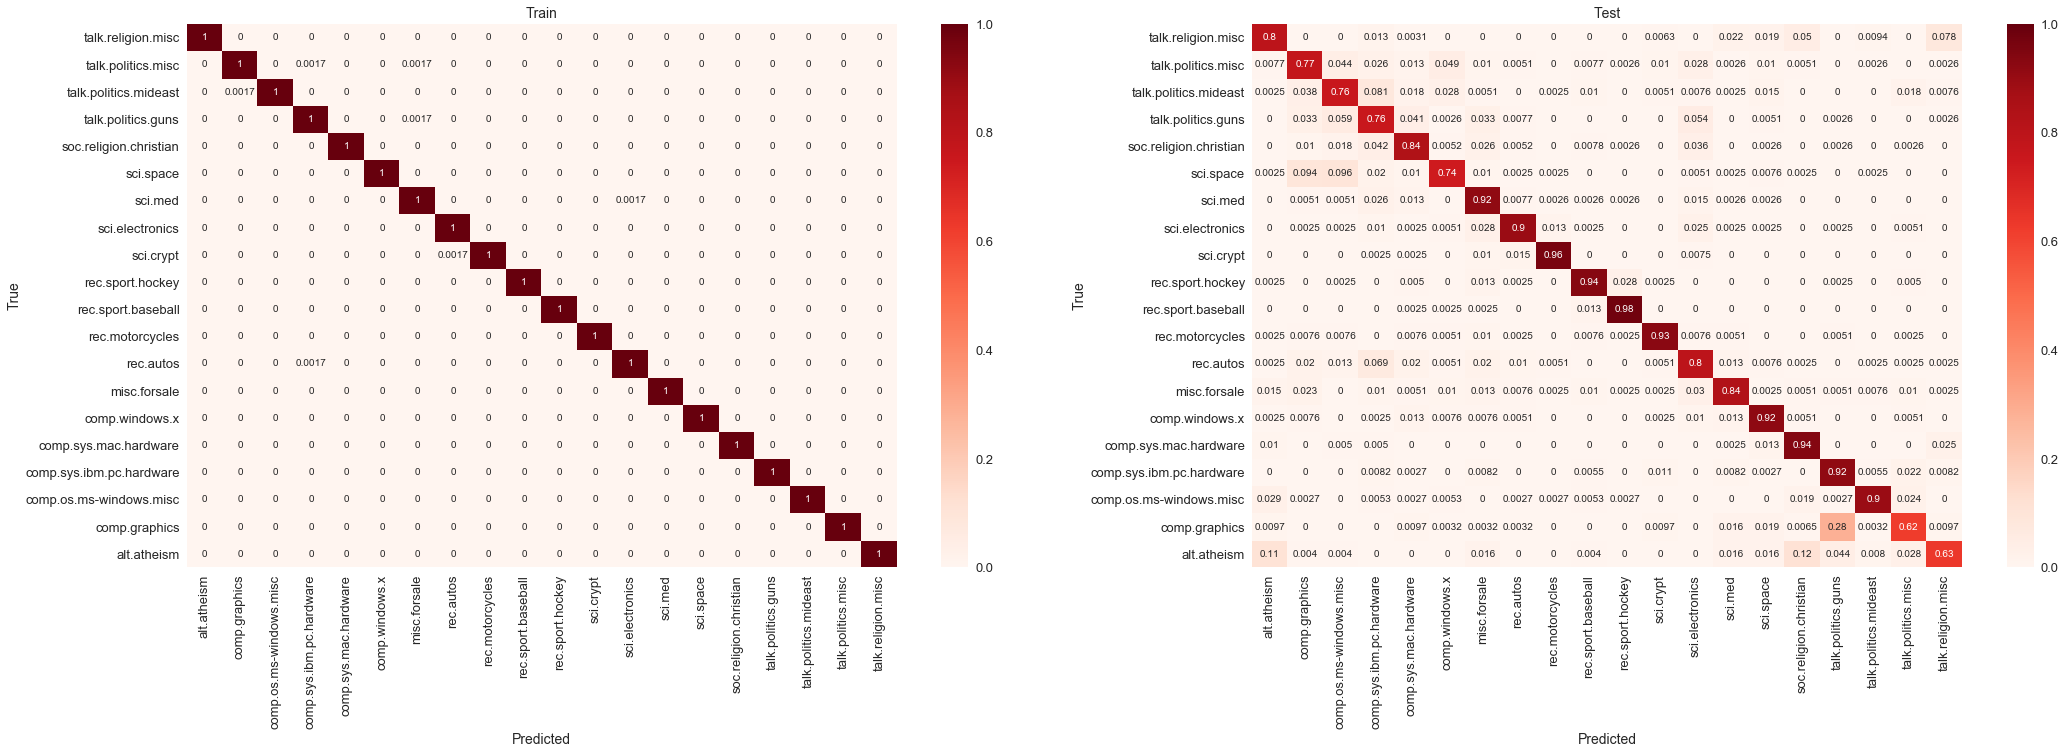

In [83]:
class_labels = newsgroup_train.target_names
plt.figure(figsize=(35, 10))

plt.subplot(121)
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train", fontsize=14)

plt.subplot(122)
g = sns.heatmap(cm_test, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test", fontsize=14);